In [1]:
import numpy as np 

import matplotlib.pyplot as plt 
import matplotlib as mpl 
# mpl.style.use("seaborn-v0_8")

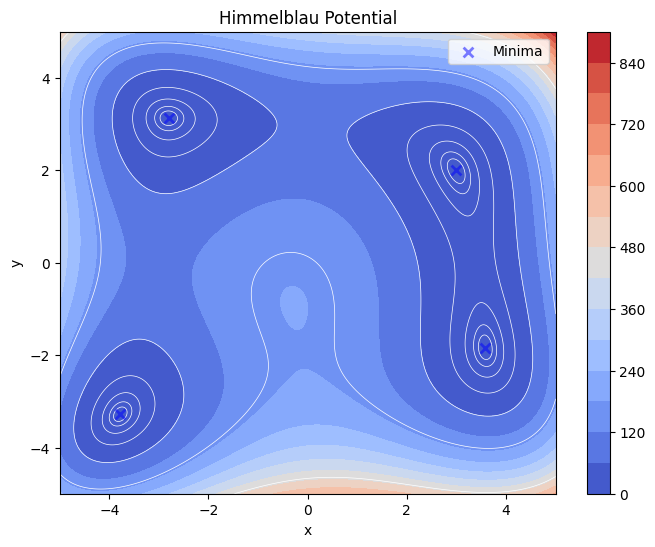

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def himmelblau(x, y): 
    return (x**2 + y - 11.)**2 + (x + y**2 - 7.)**2

# Define the grid
x_range = np.linspace(-5, 5, 1024)
y_range = np.linspace(-5, 5, 1024)
X, Y = np.meshgrid(x_range, y_range)
Z = himmelblau(X, Y)

minima = np.array([
    [3.0, 2.0],
    [-2.805118, 3.131312],
    [-3.779310, -3.283186],
    [3.584428, -1.848126]
])

plt.figure(figsize=(8, 6))

contour_plot = plt.contourf(X, Y, Z, levels=15, cmap="coolwarm")

contours = plt.contour(X, Y, Z, 
                    #    levels=20,
                       levels=np.logspace(0, 4, 10), 
                       colors='white', linewidths=0.5)
plt.scatter(minima[:, 0], minima[:, 1], 
            color='blue', s=50, marker='x', linewidths=2, alpha=0.5,
            label='Minima', zorder=2)

plt.colorbar(contour_plot)
plt.legend()

# Label axes and add title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Himmelblau Potential')

plt.show()

In [ ]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

import jax
import jax.numpy as jnp
import numpy as np
from jax import random 
from jax import grad, vmap, jit, lax

jax.config.update('jax_platform_name', 'cpu')

from functools import partial 


@jax.jit
def himmelblau(params):
    x, y = params[0], params[1]
    return (x**2 + y - 11.0)**2 + (x + y**2 - 7.0)**2

@jax.jit
def grad_himmelblau(params):
    return jax.grad(himmelblau)(params)


In [6]:
@partial(jit, static_argnames=('n_steps',))
def obabo_langevin(key, x0, n_steps, h, gamma): 
    eta = jnp.exp(-h*gamma / 2.) 
    const_sqr = jnp.sqrt(1. - eta**2)

    key, subkey = jax.random.split(key) 
    v0 = jax.random.normal(subkey, x0.shape) 

    key, subkey1, subkey2 = jax.random.split(key, 3) 
    noise_keys0 = jax.random.split(subkey1, n_steps)
    noise_keys1 = jax.random.split(subkey2, n_steps)

    noises0 = const_sqr * jax.vmap(lambda k: jax.random.normal(k, x0.shape))(noise_keys0)
    noises1 = const_sqr * jax.vmap(lambda k: jax.random.normal(k, x0.shape))(noise_keys1)

    def step(carry, noises): 
        x, v = carry 
        noise0, noise1 = noises

        grad_U0 = grad_himmelblau(x)
        
        # O step 
        vel0 = eta * v + noise0
        # B step 
        vel12 = vel0 - h / 2 * grad_U0 
        # A step 
        x1 = x + h * vel12
        # B step 
        grad_U1 = grad_himmelblau(x1)

        vel1 = vel12 - h/2 * grad_U1
        # O step 
        vel_f = eta * vel1 + noise1 

        return (x1, vel_f), jnp.stack([x1, vel_f])
    
    carry_init = (x0, v0)
    _, samples = lax.scan(step, carry_init, (noises0, noises1))

    return samples 


@partial(jit, static_argnames=('n_steps',))
def baoab_langevin(key, x0, n_steps, h, gamma):
    eta = jnp.exp(-h * gamma)
    noise_scale = jnp.sqrt(1 - eta**2)
    
    key, subkey = random.split(key)
    v0 = random.normal(subkey, x0.shape)
    
    key, subkey = random.split(key)
    noise_keys = random.split(subkey, n_steps)
    noises = noise_scale * jax.vmap(lambda k: random.normal(k, x0.shape))(noise_keys)

    def step(carry, noise):
        x_prev, v_prev = carry
        
        # First B (half-step momentum update)
        grad_U_prev = grad_himmelblau(x_prev)
        v_half = v_prev - 0.5 * h * grad_U_prev
        
        # First A (half-step position update)
        x_half = x_prev + 0.5 * h * v_half
        
        # O (full-step Ornstein-Uhlenbeck update)
        v_ou = eta * v_half + noise
        
        # Second A (half-step position update)
        x_new = x_half + 0.5 * h * v_ou
        
        # Second B (half-step momentum update)
        grad_U_new = grad_himmelblau(x_new)
        v_new = v_ou - 0.5 * h * grad_U_new

        return (x_new, v_new), jnp.stack([x_new, v_new])

    carry_init = (x0, v0)
    _, samples = lax.scan(step, carry_init, noises)

    return samples

In [11]:
key = jax.random.PRNGKey(42)
z0 = jnp.array([-4.25, 0.0])
dt = 0.1
tfinal = 4000.
gamma = .01
n_steps = int(tfinal / dt)

samples_obabo = obabo_langevin(key, z0, n_steps, dt, gamma)
samples_baoab = baoab_langevin(key, z0, n_steps, dt, gamma)


joint_samples_obabo = samples_obabo.reshape(n_steps, -1)
joint_samples_baoab = samples_baoab.reshape(n_steps, -1)


In [9]:

def himmelblau(x, y): 
    return (x**2 + y - 11.)**2 + (x + y**2 - 7.)**2

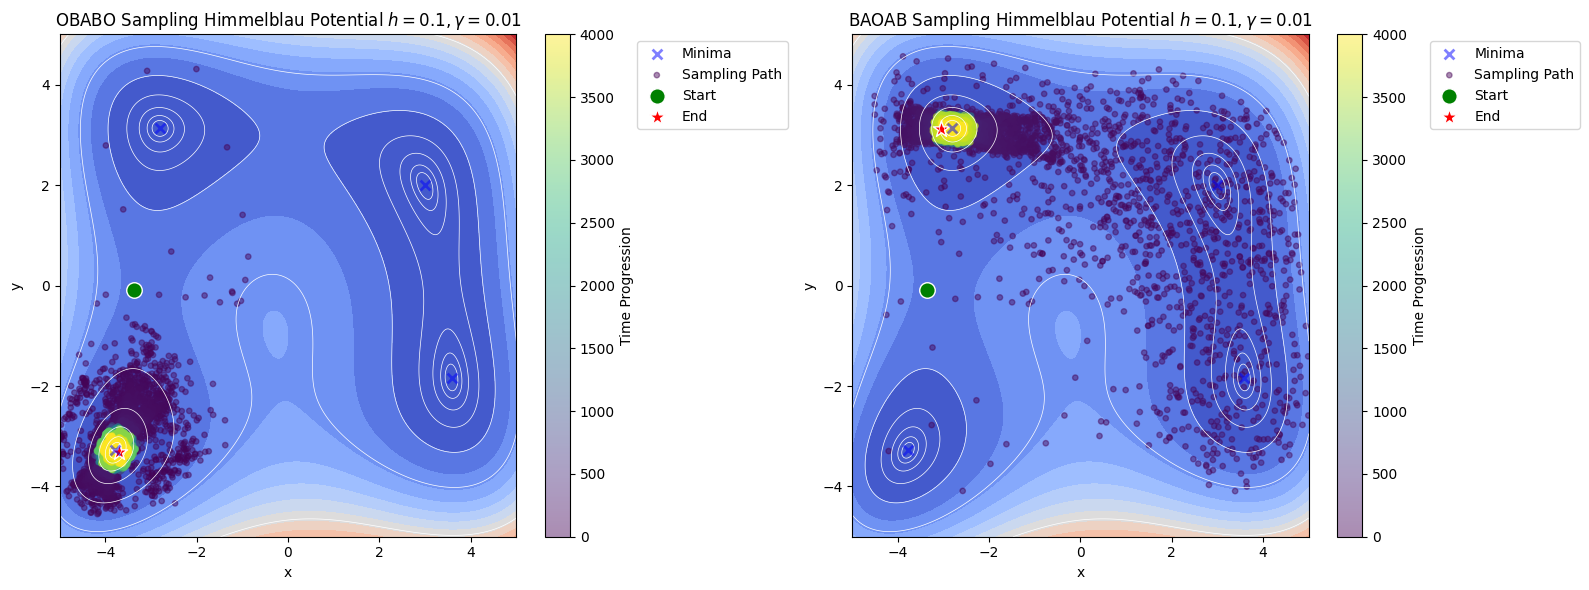

In [13]:
x_range = np.linspace(-5, 5, 1024)
y_range = np.linspace(-5, 5, 1024)
X, Y = np.meshgrid(x_range, y_range)
Z = himmelblau(X, Y)

minima = np.array([
    [3.0, 2.0],
    [-2.805118, 3.131312],
    [-3.779310, -3.283186],
    [3.584428, -1.848126]
])

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Common parameters for contours
contour_params = {
    'levels': 15,
    'cmap': 'coolwarm'
}

contour_line_params = {
    'levels': np.logspace(0, 4, 10),
    'colors': 'white',
    'linewidths': 0.5
}
for ax in (ax1, ax2):
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
# Plot OBABO results on first subplot
ax1.contourf(X, Y, Z, **contour_params)
ax1.contour(X, Y, Z, **contour_line_params)
ax1.scatter(minima[:, 0], minima[:, 1], 
            color='blue', s=50, marker='x', linewidths=2, alpha=0.5,
            label='Minima', zorder=2)

# OBABO sample data
x_pos_obabo = joint_samples_obabo[:, 0]
y_pos_obabo = joint_samples_obabo[:, 1]
time_obabo = np.linspace(0, tfinal, len(x_pos_obabo))

# OBABO plotting
sc1 = ax1.scatter(x_pos_obabo, y_pos_obabo, c=time_obabo, cmap='viridis', s=15, 
                 alpha=0.45, label='Sampling Path')
ax1.scatter(x_pos_obabo[0], y_pos_obabo[0], c='green', s=125, 
           marker='o', edgecolor='white', label='Start')
ax1.scatter(x_pos_obabo[-1], y_pos_obabo[-1], c='red', s=150, 
           marker='*', edgecolor='white', label='End')

ax1.set_title(fr'OBABO Sampling Himmelblau Potential $h={dt}, \gamma={gamma}$')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
fig.colorbar(sc1, ax=ax1, label='Time Progression')

# Plot BAOAB results on second subplot
ax2.contourf(X, Y, Z, **contour_params)
ax2.contour(X, Y, Z, **contour_line_params)
ax2.scatter(minima[:, 0], minima[:, 1], 
            color='blue', s=50, marker='x', linewidths=2, alpha=0.5,
            label='Minima', zorder=2)

# BAOAB sample data
x_pos_baoab = joint_samples_baoab[:, 0]
y_pos_baoab = joint_samples_baoab[:, 1]
time_baoab = np.linspace(0, tfinal, len(x_pos_baoab))

# BAOAB plotting
sc2 = ax2.scatter(x_pos_baoab, y_pos_baoab, c=time_baoab, cmap='viridis', s=15, 
                 alpha=0.45, label='Sampling Path')
ax2.scatter(x_pos_baoab[0], y_pos_baoab[0], c='green', s=125, 
           marker='o', edgecolor='white', label='Start')
ax2.scatter(x_pos_baoab[-1], y_pos_baoab[-1], c='red', s=150, 
           marker='*', edgecolor='white', label='End')

ax2.set_title(fr'BAOAB Sampling Himmelblau Potential $h={dt}, \gamma={gamma}$')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
fig.colorbar(sc2, ax=ax2, label='Time Progression')

# Add legends to both subplots
for ax in (ax1, ax2):
    ax.legend(bbox_to_anchor=(1.25, 1), loc='upper left')


plt.tight_layout()

plt.show()

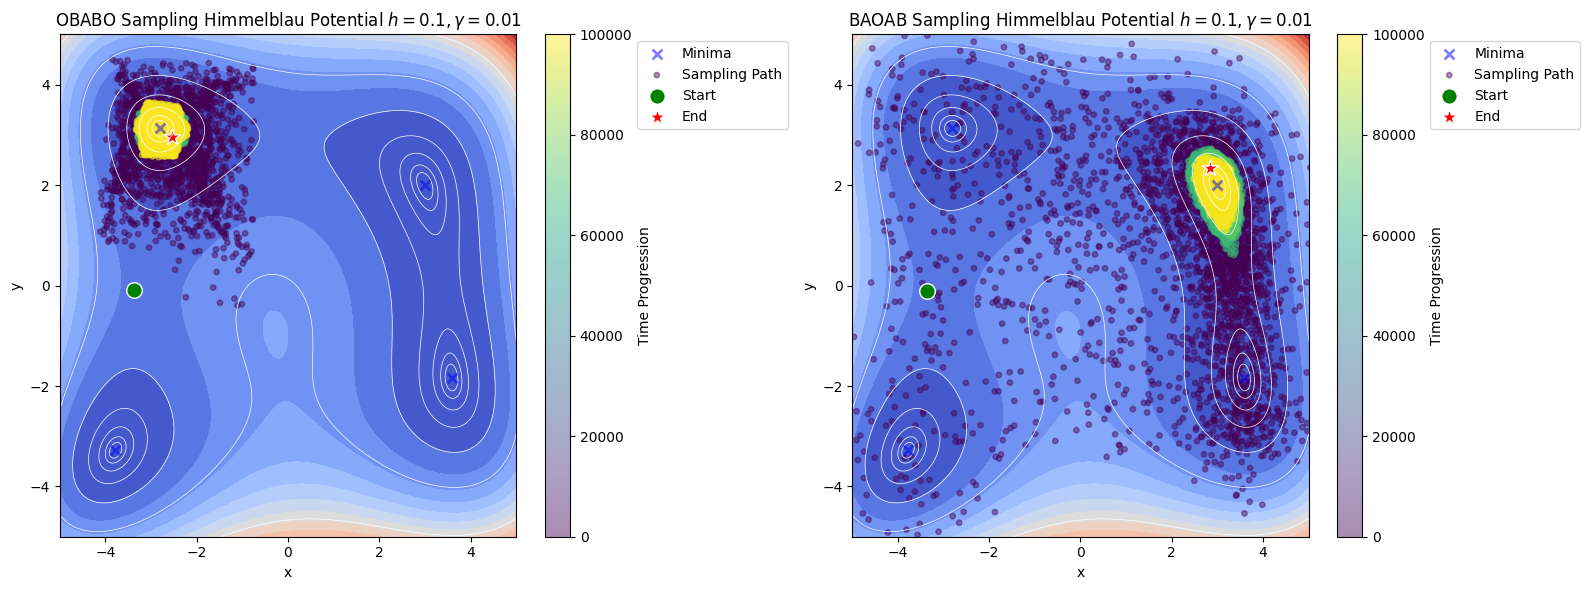

In [24]:
key = jax.random.PRNGKey(42)
z0 = jnp.array([-4.25, 0.0])
dt = 0.1
tfinal = 1e5
gamma = 0.01
n_steps = int(tfinal / dt)

samples_obabo = obabo_langevin(key, z0, n_steps, dt, gamma)
samples_baoab = baoab_langevin(key, z0, n_steps, dt, gamma)


joint_samples_obabo = samples_obabo.reshape(n_steps, -1)
joint_samples_baoab = samples_baoab.reshape(n_steps, -1)


x_range = np.linspace(-5, 5, 1024)
y_range = np.linspace(-5, 5, 1024)
X, Y = np.meshgrid(x_range, y_range)
Z = himmelblau(X, Y)

minima = np.array([
    [3.0, 2.0],
    [-2.805118, 3.131312],
    [-3.779310, -3.283186],
    [3.584428, -1.848126]
])

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Common parameters for contours
contour_params = {
    'levels': 15,
    'cmap': 'coolwarm'
}

contour_line_params = {
    'levels': np.logspace(0, 4, 10),
    'colors': 'white',
    'linewidths': 0.5
}
for ax in (ax1, ax2):
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
ax1.contourf(X, Y, Z, **contour_params)
ax1.contour(X, Y, Z, **contour_line_params)
ax1.scatter(minima[:, 0], minima[:, 1], 
            color='blue', s=50, marker='x', linewidths=2, alpha=0.5,
            label='Minima', zorder=2)

x_pos_obabo = joint_samples_obabo[:, 0]
y_pos_obabo = joint_samples_obabo[:, 1]
time_obabo = np.linspace(0, tfinal, len(x_pos_obabo))

sc1 = ax1.scatter(x_pos_obabo, y_pos_obabo, c=time_obabo, cmap='viridis', s=15, 
                 alpha=0.45, label='Sampling Path')
ax1.scatter(x_pos_obabo[0], y_pos_obabo[0], c='green', s=125, 
           marker='o', edgecolor='white', label='Start')
ax1.scatter(x_pos_obabo[-1], y_pos_obabo[-1], c='red', s=150, 
           marker='*', edgecolor='white', label='End')

ax1.set_title(fr'OBABO Sampling Himmelblau Potential $h={dt}, \gamma={gamma}$')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
fig.colorbar(sc1, ax=ax1, label='Time Progression')

ax2.contourf(X, Y, Z, **contour_params)
ax2.contour(X, Y, Z, **contour_line_params)
ax2.scatter(minima[:, 0], minima[:, 1], 
            color='blue', s=50, marker='x', linewidths=2, alpha=0.5,
            label='Minima', zorder=2)

x_pos_baoab = joint_samples_baoab[:, 0]
y_pos_baoab = joint_samples_baoab[:, 1]
time_baoab = np.linspace(0, tfinal, len(x_pos_baoab))

sc2 = ax2.scatter(x_pos_baoab, y_pos_baoab, c=time_baoab, cmap='viridis', s=15, 
                 alpha=0.45, label='Sampling Path')
ax2.scatter(x_pos_baoab[0], y_pos_baoab[0], c='green', s=125, 
           marker='o', edgecolor='white', label='Start')
ax2.scatter(x_pos_baoab[-1], y_pos_baoab[-1], c='red', s=150, 
           marker='*', edgecolor='white', label='End')

ax2.set_title(fr'BAOAB Sampling Himmelblau Potential $h={dt}, \gamma={gamma}$')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
fig.colorbar(sc2, ax=ax2, label='Time Progression')

for ax in (ax1, ax2):
    ax.legend(bbox_to_anchor=(1.25, 1), loc='upper left')


plt.tight_layout()

plt.show()

# ============